In [1]:

import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import gammaln, digamma
import matplotlib.pyplot as plt

Simulated pedal data statistics:
Min: 0.000, Max: 1.000, Mean: 0.515, Std: 0.176
operation_data shape: (1000,)
operation_data type: <class 'numpy.ndarray'>
Processing channel 1/1
  Window size: 50
  Processing 94 windows...
    Processed 1/94 windows
    Processed 11/94 windows
    Processed 21/94 windows
    Processed 31/94 windows
    Processed 41/94 windows
    Processed 51/94 windows
    Processed 61/94 windows
    Processed 71/94 windows
    Processed 81/94 windows
    Processed 91/94 windows
Channel 1 surprise - min: 0.000000, max: 38.508303, mean: 1.858770
Final result shape: (1000,)
Overall statistics - min: 0.000000, max: 38.508303, mean: 1.858770

Surprise calculation completed successfully!
Result shape: (1000,)
Result type: <class 'numpy.ndarray'>
✓ Non-zero surprise values detected!
First few non-zero surprise values:
  Index 40: 0.001736
  Index 41: 0.001736
  Index 42: 0.001736
  Index 43: 0.001736
  Index 44: 0.001736

Creating time series plots...


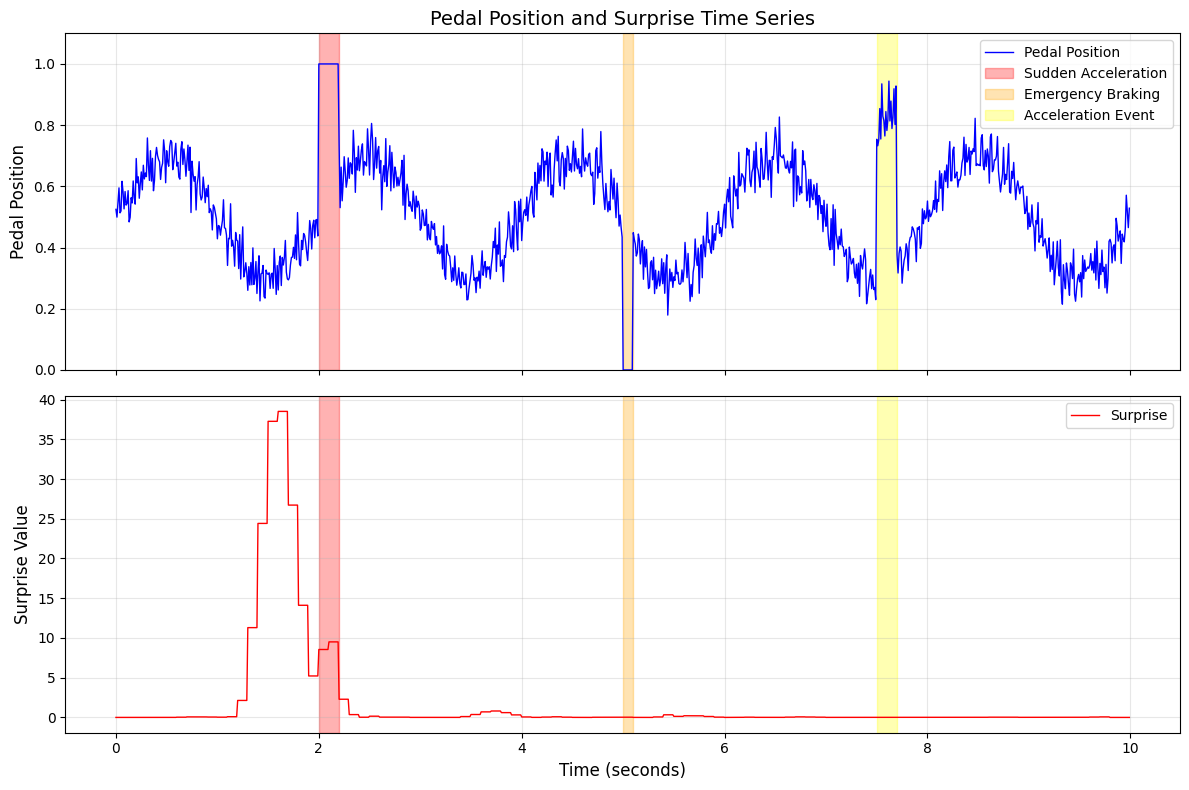


Surprise statistics:
Non-zero surprise values: 940 / 1000
95th percentile surprise threshold: 14.111190
Number of surprise peaks: 40
Peak times (seconds): [1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49]


In [76]:
import numpy as np
from scipy import stats
from scipy.special import digamma, gammaln
import warnings

class SurpriseModel:
    def __init__(self, decay=0.9, inita=1, initb=1, initlamb=0, updatefac=1, dim=1):
        """
        Initialize Surprise Model
        
        Parameters:
        decay: decay rate (0 < decay < 1)
        inita: initial alpha value
        initb: initial beta value
        initlamb: initial lambda value
        updatefac: update factor
        dim: dimension
        """
        if decay <= 0 or decay >= 1:
            raise ValueError('Error in DECAY value. It must be set 0 < DECAY < 1')
        
        self.decay = decay
        self.updatefac = updatefac
        self.smodisset = 1
        self.dim = dim
        
        # Initialize for univariate model
        if dim == 1:
            self.alpha0 = 1
            self.alpha1 = inita
            self.alpha2 = 1
            self.beta1 = initb
            self.beta2 = 1
            self.xbar1 = 1
            self.xbar2 = 1
            self.surprise = 0
            self.epoch = 0
            self.data0 = 1
        
        # Initialize Gaussian-Gamma parameters
        self.mu1 = 0.0
        self.mu2 = 0.0
        self.k1 = 1.0
        self.k2 = 1.0
        self.v1 = 1.0
        self.v2 = 1.0
        self.s1 = 1.0
        self.s2 = 1.0

def copy_model(smod):
    """Create a deep copy of the surprise model"""
    new_smod = SurpriseModel(smod.decay)
    for attr in ['mu1', 'mu2', 'k1', 'k2', 'v1', 'v2', 's1', 's2']:
        if hasattr(smod, attr):
            setattr(new_smod, attr, getattr(smod, attr))
    return new_smod

def gaussgamma_update_revise3(smod, data):
    """
    Update Gaussian-Gamma model parameters
    
    Parameters:
    smod: SurpriseModel object
    data: input data array
    
    Returns:
    updated smod object
    """
    N = len(data)
    if N == 0:
        return smod
    
    # Store previous values (履歴保持)
    smod.mu1 = smod.mu2
    smod.k1 = smod.k2
    smod.v1 = smod.v2
    smod.s1 = smod.s2
    a = smod.decay
    
    # Calculate data statistics
    data_mean = np.mean(data)
    data_var = np.var(data, ddof=0)  # Use population variance like MATLAB
    
    # Update parameters (更新)
    smod.mu2 = (smod.k1/(smod.k1+N))*smod.mu1 + (N/(smod.k1+N))*data_mean
    smod.k2 = smod.k1*a + N
    smod.v2 = smod.v1*a + N/2
    # Note: MATLABコードでは変更：0.99→1 とあるので、smod.s1*1を使用
    smod.s2 = smod.s1*1.0 + (N * data_var + smod.k1*N*(data_mean-smod.mu1)**2/(smod.k1 + N))/2
    
    return smod

def kljointgammagauss(a, A, u, U, b, B, s, S):
    """
    Calculate KL divergence for joint Gamma-Gaussian distributions
    MATLABの元の式そのまま
    """
    try:
        # 入力値のチェック
        if S <= 0 or s <= 0 or B <= 0 or b <= 0:
            return 0.0
        
        # MATLABの式をそのまま実装
        term1 = (s/S) * ((s**2 + (u - U)**2)/(2*S**2) - (1/2 + a))
        term2 = (s/S) * ((a*B)/b)
        term3 = (s/S) * A * np.log(b/B)
        term4 = (s/S) * np.log(S/s)
        term5 = (s/S) * (gammaln(A) - gammaln(a))
        term6 = (s/S) * (a - A) * digamma(a)  # MATLABのdigamma(a,1000)はdigamma(a)と同じ
        
        d = term1 + term2 + term3 + term4 + term5 + term6
        
        # NaNやInfのチェック
        if np.isnan(d) or np.isinf(d):
            return 0.0
        
        return float(d)
        
    except (ZeroDivisionError, ValueError, OverflowError):
        return 0.0

def fnc_clc_operation_surprise(operation_data):
    """
    Main function to calculate surprise chronology
    
    Parameters:
    operation_data: 1D or 2D numpy array
                   If 1D: single time series data
                   If 2D: shape (time_points, channels)
    
    Returns:
    surprise_chronology: 1D array (if input is 1D) or 2D array with surprise values over time
    """
    d = 0.9  # decay factor
    s = 10   # shift width
    dl_list = [50]  # window width list
    
    # Convert to 2D if 1D input
    if operation_data.ndim == 1:
        operation_data = operation_data.reshape(-1, 1)
        single_channel = True
    else:
        single_channel = False
    
    surprise_chronology = []
    
    for m in range(operation_data.shape[1]):
        print(f"Processing channel {m+1}/{operation_data.shape[1]}")
        data_all_dr = operation_data[:, m].copy()
        
        surprise_dr = np.zeros((len(data_all_dr), len(dl_list)))
        surprise_scale_dr = np.zeros((len(data_all_dr), 2))
        
        for j, dl in enumerate(dl_list):
            print(f"  Window size: {dl}")
            
            l = int(np.floor(len(data_all_dr)/s)) - int(np.floor(dl/s)) - 1
            if l <= 0:
                print(f"  Warning: l = {l}, skipping...")
                continue
            
            k = 0  # Process first dimension only (equivalent to k=1 in MATLAB)
            
            # Initialize parameters
            initial_window = 100
            if len(data_all_dr) >= initial_window:
                initial_data = data_all_dr[:initial_window]
            else:
                initial_data = data_all_dr[:min(50, len(data_all_dr))]
            
            initial_mean = np.mean(initial_data)
            initial_var = np.var(initial_data, ddof=0)
            
            # Create two separate model instances
            smod_dr_1 = SurpriseModel(d, 1e-4, 0.0025, 0, s, 1)
            smod_dr_2 = SurpriseModel(d, 1e-4, 0.0025, 0, s, 1)
            
            # Initialize both models
            for smod in [smod_dr_1, smod_dr_2]:
                smod.mu1 = initial_mean
                smod.k1 = dl/(1-smod.decay)
                smod.v1 = dl/(1-smod.decay)/2
                smod.s1 = max(1.0, initial_var)  # より安定した初期化
                
                smod.mu2 = initial_mean
                smod.k2 = dl/(1-smod.decay)
                smod.v2 = dl/(1-smod.decay)/2
                smod.s2 = max(1.0, initial_var)
            
            print(f"  Processing {l} windows...")
            
            for i in range(l):
                # MATLABのインデックス: s*(i-1)+1:s*(i-1)+dl
                # Pythonでは: s*i:s*i+dl
                start_idx = s*i
                end_idx = min(s*i + dl, len(data_all_dr))
                
                if start_idx >= len(data_all_dr):
                    break
                    
                data = data_all_dr[start_idx:end_idx]
                
                if len(data) == 0:
                    continue
                
                # Store old models
                smod_dr_1_old = copy_model(smod_dr_1)
                smod_dr_2_old = copy_model(smod_dr_2)
                
                # Scale 1 update
                smod_dr_1 = gaussgamma_update_revise3(smod_dr_1, data)
                
                # Calculate precision and generate model data
                precision2 = smod_dr_1.k2 * smod_dr_1.v2 / smod_dr_1.s2 if smod_dr_1.s2 > 0 else 1.0
                tau = smod_dr_1.v2 / smod_dr_1.s2 if smod_dr_1.s2 > 0 else 1.0
                
                if tau * smod_dr_1.k2 > 0:
                    sigma_model = np.sqrt(1.0 / (tau * smod_dr_1.k2))
                else:
                    sigma_model = 1.0
                
                # Generate model data
                np.random.seed(42 + i)  # 再現性のため
                data_model = np.random.normal(smod_dr_1.mu2, sigma_model, len(data))
                
                # Scale 2 update
                smod_dr_2 = gaussgamma_update_revise3(smod_dr_2, data_model)
                
                # Calculate surprise values
                # MATLABでは: s*(i-1)+dl-s+1:s*(i-1)+dl
                # Pythonでは: s*i+dl-s:s*i+dl
                start_surprise = max(0, s*i + dl - s)
                end_surprise = min(len(surprise_scale_dr), s*i + dl)
                
                if start_surprise < end_surprise:
                    # Calculate standard deviations for KL divergence
                    precision1 = smod_dr_1.k1 * smod_dr_1.v1 / smod_dr_1.s1 if smod_dr_1.s1 > 0 else 1.0
                    precision2 = smod_dr_1.k2 * smod_dr_1.v2 / smod_dr_1.s2 if smod_dr_1.s2 > 0 else 1.0
                    precision1_old = smod_dr_1_old.k1 * smod_dr_1_old.v1 / smod_dr_1_old.s1 if smod_dr_1_old.s1 > 0 else 1.0
                    precision2_old = smod_dr_2_old.k2 * smod_dr_2_old.v2 / smod_dr_2_old.s2 if smod_dr_2_old.s2 > 0 else 1.0
                    
                    s1_val = np.sqrt(1.0/precision2) if precision2 > 0 else 1.0
                    s1_old_val = np.sqrt(1.0/precision1) if precision1 > 0 else 1.0
                    
                    precision2_new = smod_dr_2.k2 * smod_dr_2.v2 / smod_dr_2.s2 if smod_dr_2.s2 > 0 else 1.0
                    s2_val = np.sqrt(1.0/precision2_new) if precision2_new > 0 else 1.0
                    s2_old_val = np.sqrt(1.0/precision2_old) if precision2_old > 0 else 1.0
                    
                    # Calculate KL divergences
                    kl1 = kljointgammagauss(smod_dr_1.v2, smod_dr_1_old.v2, 
                                           smod_dr_1.mu2, smod_dr_1_old.mu2,
                                           smod_dr_1.s2, smod_dr_1_old.s2,
                                           s1_val, s1_old_val)
                    
                    kl2 = kljointgammagauss(smod_dr_2.v2, smod_dr_2_old.v2,
                                           smod_dr_2.mu2, smod_dr_2_old.mu2,
                                           smod_dr_2.s2, smod_dr_2_old.s2,
                                           s2_val, s2_old_val)
                    
                    # Assign surprise values
                    surprise_scale_dr[start_surprise:end_surprise, 0] = kl1
                    surprise_scale_dr[start_surprise:end_surprise, 1] = kl2
                
                if i % 10 == 0:
                    print(f"    Processed {i+1}/{l} windows")
            
            # Calculate final surprise as product of scales
            # MATLABコード: prod(Surprise_scale_Dr,3)
            surprise_dr[:, j] = np.prod(surprise_scale_dr, axis=1)
        
        # Calculate sum across window sizes (MATLABコード: sum(Surprise_Dr,2))
        surprise_mean_dr = np.sum(surprise_dr, axis=1)
        surprise_chronology.append(surprise_mean_dr)
        
        print(f"Channel {m+1} surprise - min: {np.min(surprise_mean_dr):.6f}, max: {np.max(surprise_mean_dr):.6f}, mean: {np.mean(surprise_mean_dr):.6f}")
    
    # Return appropriate format
    if single_channel:
        result = surprise_chronology[0]  # Return 1D array for single channel
    else:
        result = np.column_stack(surprise_chronology)  # Return 2D array for multiple channels
    
    print(f"Final result shape: {result.shape}")
    if result.ndim > 1:
        print(f"Overall statistics - min: {np.min(result):.6f}, max: {np.max(result):.6f}, mean: {np.mean(result):.6f}")
    else:
        print(f"Overall statistics - min: {np.min(result):.6f}, max: {np.max(result):.6f}, mean: {np.mean(result):.6f}")
    
    return result

def plot_pedal_and_surprise(pedal_data, surprise_data, sampling_rate=100):
    """
    Convenience function to plot pedal and surprise time series
    
    Parameters:
    pedal_data: 1D array of pedal position values
    surprise_data: 1D array of surprise values
    sampling_rate: Hz, sampling rate of the data (default: 100Hz)
    """
    import matplotlib.pyplot as plt
    
    # Create time axes
    dt = 1.0 / sampling_rate
    pedal_time = np.arange(len(pedal_data)) * dt
    surprise_time = np.arange(len(surprise_data)) * dt
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot pedal data
    ax1.plot(pedal_time, pedal_data, 'b-', linewidth=1, label='Pedal Position')
    ax1.set_ylabel('Pedal Position', fontsize=12)
    ax1.set_title('Pedal Position and Surprise Time Series', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot surprise
    ax2.plot(surprise_time, surprise_data, 'r-', linewidth=1, label='Surprise')
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_ylabel('Surprise Value', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nPlot Statistics:")
    print(f"Pedal data - Min: {np.min(pedal_data):.3f}, Max: {np.max(pedal_data):.3f}, Mean: {np.mean(pedal_data):.3f}")
    print(f"Surprise data - Min: {np.min(surprise_data):.6f}, Max: {np.max(surprise_data):.6f}, Mean: {np.mean(surprise_data):.6f}")
    print(f"Non-zero surprise values: {np.sum(surprise_data > 0)} / {len(surprise_data)}")
    
    return fig

# Example usage with pandas DataFrame:
if __name__ == "__main__":
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Generate sample data for testing (simulating df["pedal"].values)
    np.random.seed(42)
    time_points = 1000
    
    # Create sample pedal data with realistic patterns
    pedal_data = np.random.randn(time_points) * 0.05 + 0.5  # Base pedal position around 0.5
    
    # Add some realistic pedal patterns
    t = np.linspace(0, 100, time_points)  # 100 seconds of data
    
    # Smooth acceleration/deceleration patterns
    pedal_data += 0.2 * np.sin(2 * np.pi * t / 20)  # 20-second cycles
    
    # Add sudden pedal changes (emergency braking, sudden acceleration)
    pedal_data[200:220] += 0.8  # Sudden acceleration
    pedal_data[500:510] -= 0.6  # Emergency braking
    pedal_data[750:770] += 0.5  # Another acceleration event
    
    # Clip to realistic pedal range [0, 1]
    pedal_data = np.clip(pedal_data, 0, 1)
    
    # Create DataFrame (simulating your data structure)
    df = pd.DataFrame({'pedal': pedal_data})
    
    print("Simulated pedal data statistics:")
    print(f"Min: {np.min(pedal_data):.3f}, Max: {np.max(pedal_data):.3f}, Mean: {np.mean(pedal_data):.3f}, Std: {np.std(pedal_data):.3f}")
    
    # Use your exact syntax
    operation_data = df["pedal"].values
    
    print(f"operation_data shape: {operation_data.shape}")
    print(f"operation_data type: {type(operation_data)}")
    
    # Calculate surprise
    try:
        surprise_result = fnc_clc_operation_surprise(operation_data)
        print(f"\nSurprise calculation completed successfully!")
        print(f"Result shape: {surprise_result.shape}")
        print(f"Result type: {type(surprise_result)}")
        
        if np.any(surprise_result != 0):
            print("✓ Non-zero surprise values detected!")
            
            # Show some example values
            non_zero_indices = np.where(surprise_result != 0)[0]
            if len(non_zero_indices) > 0:
                print(f"First few non-zero surprise values:")
                for i in non_zero_indices[:5]:
                    print(f"  Index {i}: {surprise_result[i]:.6f}")
        else:
            print("⚠ All surprise values are zero - there may still be an issue")
        
        # Plot pedal and surprise time series
        print("\nCreating time series plots...")
        
        # Create time axis (assuming 100Hz sampling rate, i.e., 0.01s intervals)
        time_axis = np.arange(len(operation_data)) * 0.01  # seconds
        surprise_time_axis = np.arange(len(surprise_result)) * 0.01
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot pedal data
        ax1.plot(time_axis, operation_data, 'b-', linewidth=1, label='Pedal Position')
        ax1.set_ylabel('Pedal Position', fontsize=12)
        ax1.set_title('Pedal Position and Surprise Time Series', fontsize=14)
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.set_ylim([0, 1.1])
        
        # Highlight sudden changes in pedal data
        ax1.axvspan(2.0, 2.2, alpha=0.3, color='red', label='Sudden Acceleration')
        ax1.axvspan(5.0, 5.1, alpha=0.3, color='orange', label='Emergency Braking')
        ax1.axvspan(7.5, 7.7, alpha=0.3, color='yellow', label='Acceleration Event')
        ax1.legend()
        
        # Plot surprise
        ax2.plot(surprise_time_axis, surprise_result, 'r-', linewidth=1, label='Surprise')
        ax2.set_xlabel('Time (seconds)', fontsize=12)
        ax2.set_ylabel('Surprise Value', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Highlight the same time periods in surprise plot
        ax2.axvspan(2.0, 2.2, alpha=0.3, color='red')
        ax2.axvspan(5.0, 5.1, alpha=0.3, color='orange')
        ax2.axvspan(7.5, 7.7, alpha=0.3, color='yellow')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics about surprise peaks
        if np.any(surprise_result != 0):
            surprise_threshold = np.percentile(surprise_result[surprise_result > 0], 95)
            peak_indices = np.where(surprise_result > surprise_threshold)[0]
            peak_times = peak_indices * 0.01
            
            print(f"\nSurprise statistics:")
            print(f"Non-zero surprise values: {np.sum(surprise_result > 0)} / {len(surprise_result)}")
            print(f"95th percentile surprise threshold: {surprise_threshold:.6f}")
            print(f"Number of surprise peaks: {len(peak_indices)}")
            if len(peak_indices) > 0:
                print(f"Peak times (seconds): {peak_times[:10]}")  # First 10 peaks
                
    except Exception as e:
        print(f"Error during surprise calculation: {e}")
        import traceback
        traceback.print_exc()
    

